In [114]:
import os
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [115]:
# Configuración general
folder_path = r"C:\Users\Ibon\PycharmProjects\Microgrid\TrainTestSplit"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [116]:
# Función para cargar y preprocesar datos (usada tanto para entrenamiento como para test)
def load_and_preprocess(files, all_sources):
    df_list = []
    for file in files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, parse_dates=["Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss"])
        df = df.drop(columns='Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss')
        # Muestreo estratificado
        df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))
        df_list.append(df_sampled)
    full_df = pd.concat(df_list, ignore_index=True)
    
    # One-hot encoding con categorías fijas
    full_df['source'] = pd.Categorical(full_df['source'], categories=all_sources)
    full_df = pd.get_dummies(full_df, columns=['source'], prefix='src', dtype=np.float32)
    
    return full_df


In [117]:
# Función para preparar tensores a partir de DataFrame
def prepare_data(df, scaler=None):
    # Separar características y target
    X = df.drop(columns=['Pmp (W)']).values.astype(np.float32)
    y = df['Pmp (W)'].values.astype(np.float32)
    if scaler is None:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    else:
        X = scaler.transform(X)
    X_tensor = torch.tensor(X).to(device)
    y_tensor = torch.tensor(y).unsqueeze(1).to(device)
    return X_tensor, y_tensor, scaler

In [118]:
# Definición del modelo
class EnhancedDNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.model(x)

In [119]:
# Parámetros del Federated Learning
federated_rounds = 5         # número de rondas federadas
local_epochs = 40             # épocas locales por cada ronda
batch_size = 512
lr = 0.0001
weight_decay = 1e-4

In [120]:
# Definir los clientes y sus archivos de entrenamiento
clients = {
    "cocoa": [f for f in os.listdir(folder_path) if f.endswith('.csv') and "train" in f and "cocoa" in f.lower()],
    "eugene": [f for f in os.listdir(folder_path) if f.endswith('.csv') and "train" in f and "eugene" in f.lower()],
    "golden": [f for f in os.listdir(folder_path) if f.endswith('.csv') and "train" in f and "golden" in f.lower()]
}

# Para test, se puede hacer lo mismo (o unir todos los test en uno solo)
test_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and "test" in f]


In [121]:
# Antes de cualquier preprocesamiento, recolectar TODAS las categorías posibles de 'source'
all_sources = set()

# Recolectar de los clientes
for client_files in clients.values():
    for file in client_files:
        file_path = os.path.join(folder_path, file)
        df_temp = pd.read_csv(file_path, usecols=['source'])
        all_sources.update(df_temp['source'].unique())

# Recolectar de los archivos de test
for test_file in test_files:
    file_path = os.path.join(folder_path, test_file)
    df_temp = pd.read_csv(file_path, usecols=['source'])
    all_sources.update(df_temp['source'].unique())

all_sources = sorted(all_sources)  # Ordenar para consistencia

In [122]:
# Cargar datos iniciales (cocoa) con todas las categorías
temp_df = load_and_preprocess(clients["cocoa"], all_sources)
X_temp, y_temp, scaler = prepare_data(temp_df)  # Ahora scaler se entrena con todas las features

# Procesar test_df con las mismas categorías
test_df = load_and_preprocess(test_files, all_sources)

input_dim = X_temp.shape[1]

print("Columnas del dataset de entrenamiento:", temp_df.columns)
print("Columnas del dataset de test:", test_df.columns)

Columnas del dataset de entrenamiento: Index(['POA irradiance CMP22 pyranometer (W/m2)',
       'PV module back surface temperature (degC)', 'Pmp (W)',
       'Dry bulb temperature (degC)', 'Relative humidity (%RH)',
       'Atmospheric pressure (mb)',
       'Precipitation (mm) accumulated daily total',
       'Direct normal irradiance (W/m2)',
       'Global horizontal irradiance (W/m2)',
       'Diffuse horizontal irradiance (W/m2)', 'src_Cocoa_CIGS39017.csv',
       'src_Cocoa_CIGS8-001.csv', 'src_Cocoa_CdTe75638.csv',
       'src_Cocoa_HIT05667.csv', 'src_Cocoa_aSiMicro03036.csv',
       'src_Cocoa_aSiTandem72-46.csv', 'src_Cocoa_aSiTriple28324.csv',
       'src_Cocoa_mSi0166.csv', 'src_Cocoa_mSi0188.csv',
       'src_Cocoa_mSi460A8.csv', 'src_Cocoa_xSi12922.csv',
       'src_Eugene_CIGS39017.csv', 'src_Eugene_CIGS8-001.csv',
       'src_Eugene_CdTe75638.csv', 'src_Eugene_HIT05667.csv',
       'src_Eugene_aSiMicro03036.csv', 'src_Eugene_aSiTandem72-46.csv',
       'src_Eugene_aSiT

In [123]:
# Inicializar modelo global
global_model = EnhancedDNN(input_dim).to(device)
global_model.train()

EnhancedDNN(
  (model): Sequential(
    (0): Linear(in_features=42, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [124]:
# Función de entrenamiento local
def local_train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        avg_loss = running_loss / len(train_loader.dataset)
        # Se puede imprimir la pérdida local si se desea:
        print(f"Local epoch {epoch+1}, Loss: {avg_loss:.4f}")
    return model.state_dict(), len(train_loader.dataset)

In [125]:
# Definir la función para promediar los pesos (FedAvg) ponderados por el tamaño del dataset
def fed_avg(state_dicts, data_sizes):
    avg_state = copy.deepcopy(state_dicts[0])
    total_samples = sum(data_sizes)

    for key in avg_state.keys():
        # Verificar si el tensor es de tipo entero (LongTensor)
        if avg_state[key].dtype in [torch.int64, torch.long]:
            # No promediamos los tensores enteros, solo copiamos el valor del primer cliente
            avg_state[key] = state_dicts[0][key].clone()
        else:
            # Inicializar con ceros en tipo float32
            avg_state[key] = torch.zeros_like(avg_state[key], dtype=torch.float32)

            # Promediar los parámetros de tipo float
            for state, size in zip(state_dicts, data_sizes):
                weight = size / total_samples
                avg_state[key] += state[key].float() * weight

    return avg_state



In [126]:
# Comenzamos la simulación de Federated Learning
criterion = nn.MSELoss()
# Variables para guardar el mejor modelo federado
best_test_loss = np.inf
best_federated_model_path = "best_federated_model.pth"

print("=== Iniciando entrenamiento federado ===")
for round in range(1, federated_rounds+1):
    print(f"\n--- Ronda Federada {round} ---")
    local_state_dicts = []
    data_sizes = []
    # Entrenamiento local para cada cliente
    for client_name, files in clients.items():
        print(f"Entrenando cliente: {client_name}")
        client_df = load_and_preprocess(files, all_sources)
        X_local, y_local, _ = prepare_data(client_df, scaler)
        local_dataset = TensorDataset(X_local, y_local)
        local_loader = DataLoader(local_dataset, batch_size=batch_size, shuffle=True)
        
        # Clonar el modelo global para entrenamiento local
        local_model = copy.deepcopy(global_model)
        optimizer_local = optim.Adam(local_model.parameters(), lr=lr, weight_decay=weight_decay)
        
        # Entrenamiento local
        local_state, n_samples = local_train(local_model, local_loader, criterion, optimizer_local, local_epochs)
        local_state_dicts.append(local_state)
        data_sizes.append(n_samples)
    
    # Promediar (FedAvg) los pesos de los clientes para actualizar el modelo global
    global_state = fed_avg(local_state_dicts, data_sizes)
    global_model.load_state_dict(global_state)
    print(f"Ronda {round} completada. Se han promediado los pesos de {len(clients)} clientes.")
    
    # Evaluación en el conjunto de test después de cada ronda
    X_test_tensor, y_test_tensor, _ = prepare_data(test_df, scaler)
    global_model.eval()
    with torch.no_grad():
        y_pred = global_model(X_test_tensor).cpu().numpy()
        y_test_np = y_test_tensor.cpu().numpy()
        test_loss = mean_squared_error(y_test_np, y_pred)
        print(f"Test MSE después de ronda {round}: {test_loss:.4f}")
    
    # Guardar el modelo si mejora
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(global_model.state_dict(), best_federated_model_path)
        print(f"Nuevo mejor modelo federado guardado: {best_federated_model_path}")



=== Iniciando entrenamiento federado ===

--- Ronda Federada 1 ---
Entrenando cliente: cocoa
Local epoch 1, Loss: 1515.4080
Local epoch 2, Loss: 80.1815
Local epoch 3, Loss: 56.6040
Local epoch 4, Loss: 50.1850
Local epoch 5, Loss: 45.7742
Local epoch 6, Loss: 42.8415
Local epoch 7, Loss: 39.6037
Local epoch 8, Loss: 39.3454
Local epoch 9, Loss: 37.6377
Local epoch 10, Loss: 36.5518
Local epoch 11, Loss: 34.6714
Local epoch 12, Loss: 34.2522
Local epoch 13, Loss: 33.6746
Local epoch 14, Loss: 32.6134
Local epoch 15, Loss: 31.7288
Local epoch 16, Loss: 30.9536
Local epoch 17, Loss: 30.2775
Local epoch 18, Loss: 30.0192
Local epoch 19, Loss: 30.0816
Local epoch 20, Loss: 29.9082
Local epoch 21, Loss: 28.5408
Local epoch 22, Loss: 28.6165
Local epoch 23, Loss: 28.1384
Local epoch 24, Loss: 28.8780
Local epoch 25, Loss: 27.4327
Local epoch 26, Loss: 27.1898
Local epoch 27, Loss: 26.5793
Local epoch 28, Loss: 26.7871
Local epoch 29, Loss: 26.5564
Local epoch 30, Loss: 26.2847
Local epoch 31


=== Evaluación Final del Mejor Modelo Federado ===
Test MSE: 270.9522
Test MAE: 8.7073
Test R2: 0.8128


C:\Users\Ibon\AppData\Local\Temp\ipykernel_2476\528032156.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  global_model.load_state_dict(torch.load(best_federated_model_pa

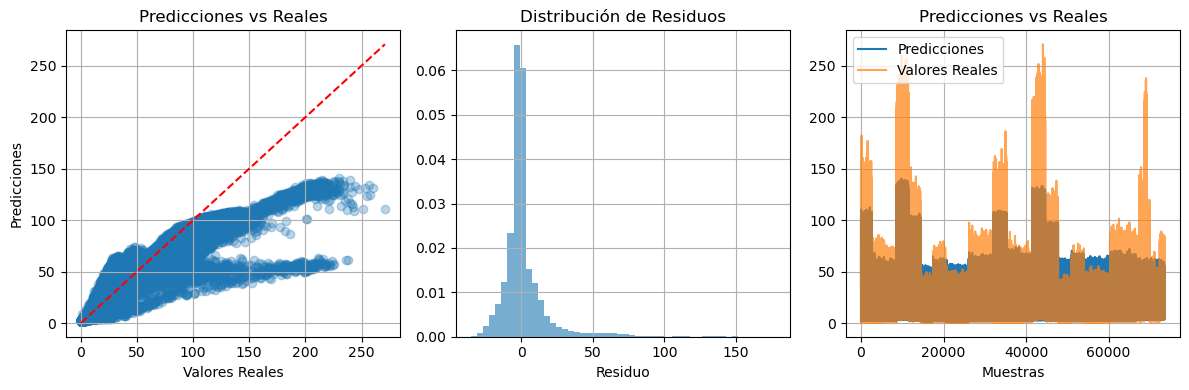

In [127]:
# Evaluación final del modelo global (o el mejor modelo guardado)
global_model.load_state_dict(torch.load(best_federated_model_path))
global_model.eval()
with torch.no_grad():
    y_pred = global_model(X_test_tensor).cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    mse = mean_squared_error(y_test_np, y_pred)
    mae = mean_absolute_error(y_test_np, y_pred)
    r2 = r2_score(y_test_np, y_pred)
    print("\n=== Evaluación Final del Mejor Modelo Federado ===")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R2: {r2:.4f}")

# (Opcional) Graficar resultados en Test
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title('Predicciones vs Reales')
plt.scatter(y_test_np, y_pred, alpha=0.3)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.grid(True)

plt.subplot(132)
residuals = y_test_np - y_pred
plt.hist(residuals, bins=50, density=True, alpha=0.6)
plt.title('Distribución de Residuos')
plt.xlabel('Residuo')
plt.grid(True)

plt.subplot(133)
plt.plot(y_pred, label="Predicciones")
plt.plot(y_test_np, label="Valores Reales", alpha=0.7)
plt.title('Predicciones vs Reales')
plt.xlabel('Muestras')
plt.legend() 
plt.grid(True)
plt.tight_layout()
plt.show()